# Code for Producing Figure 6

### From the paper:  
**"Fractal clusters and urban scaling shape spatial inequality in U.S. patenting"**, published in npj Complexity,  https://doi.org/10.1038/s44260-025-00054-y

**Authors:**  
Salva Duran-Nebreda, Blai Vidiella,  R. Alexander Bentley and Sergi Valverde

**Date:** September 8, 2025  
**Location:** Barcelona  
**Group:** Evolution of Networks Lab |  https://svalver.github.io  
**E-mail:** svalver@gmail.com

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import networkx as nx

# the following import may require "conda install -c conda-forge basemap"
# see: https://www.geeksforgeeks.org/python/how-to-fix-the-no-module-named-mpl_toolkits-basemap-error-in-python/
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable

# --- custom modules ----
from inequality import *
# this may require the following packages:
#pip install ipywidgets widgetsnbextension pandas-profiling
from cv_peak import * 
from citymap import CityMapPlotter

In [2]:
# change this to the folder where you have the simulation data
DATAFOLDER = './Data/'

In [3]:
# Algorithm Parameters
p = 3   # reinforcement strength (cumulative advantage) 
v = 1   # (v_0) initial entry rate for new locations
Lambda = 0.0004 # decay rate of entry probability 
df = 1  # jump parameter

# --- Panel: Zipf law ---
zipf = pd.DataFrame(columns=['Rank','Count','replicate'])
all_points_x = []
all_points_y = []

for replicate in range(10): # 25):
    path = DATAFOLDER + f'PolyaLevy_Entrenchment_p{p}_v{v}_r{replicate}'

    locations = {}
    with open(path + '.txt', 'r') as file:
        first = False
        for line in file:
            if first:
                coords = line[1:-2].split(',')
                city = (float(coords[0]), float(coords[1]))
                locations[city] = locations.get(city, 0) + 1
            else:
                first = True

    freq = sorted(locations.values(), reverse=True)
    rank = np.arange(1, len(freq) + 1)

    for i in range(len(rank)):
        zipf = pd.concat([zipf, pd.DataFrame([[rank[i], freq[i], replicate]], columns=['Rank','Count','replicate'])])
    all_points_y += freq
    all_points_x += list(rank)

params = np.polyfit(np.log10(all_points_x), np.log10(all_points_y), 1)

# ----------------------- Panel: Zipf Morphospace ---
df_morpho = pd.DataFrame(columns=['v','p','alpha','error'])
data = pd.read_csv(DATAFOLDER + 'pv_Morphospace_error10.5.csv')
for p_ in [1,2,3,4]:
    for v_ in [0.5,1]:
        data_ = pd.read_csv(DATAFOLDER + f'pv_Morphospace_error{p_}{v_}.csv')
        data = pd.concat((data, data_))
data.reset_index(drop=True, inplace=True)
data.drop_duplicates(inplace=True)
for v_ in data['v'].unique():
    data_v = data[data['v'] == v_]
    for p_ in data['p'].unique():
        data_vp = data_v[data_v['p'] == p_]
        if p_ == 0 or v_ == 0:
            average_alpha = -0.1 if p_ == 0 else -2
            average_error = 0.6 if p_ == 0 else 500
        else:
            average_alpha = data_vp['alpha'].mean()
            average_error = data_vp['error'].mean()
        df_morpho = pd.concat([df_morpho, pd.DataFrame([[v_,p_,average_alpha,average_error]], columns=['v','p','alpha','error'])])
M = df_morpho.pivot(index="p", columns="v", values="alpha")


/var/folders/0p/7lmr8bnx25z86qtgtdv9h4br0000gn/T/ipykernel_32158/3498666816.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_morpho = pd.concat([df_morpho, pd.DataFrame([[v_,p_,average_alpha,average_error]], columns=['v','p','alpha','error'])])


In [4]:
def heatmap_coords(M, v_val, p_val):
    x = M.columns.get_loc(v_val) + 0.5
    y = M.index.get_loc(p_val) + 0.5
    
    # Reverse the vertical index because heatmap inverts y-axis
    # y = len(M.index) - M.index.get_loc(p_val) - 0.5
    return x, y

In [5]:

# --- Panel: Omega / Diversity of locations ---
Omega = pd.DataFrame(columns=['t', 'Omega', 'D', 'replicate'])
for replicate in range(10): # range(25):
    path = DATAFOLDER + f'PolyaLevy_Entrenchment_p{p}_v{v}_r{replicate}'
    data = pd.read_csv(path + '.csv')
    Omega = pd.concat([Omega, data])

/var/folders/0p/7lmr8bnx25z86qtgtdv9h4br0000gn/T/ipykernel_32158/3707460600.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  Omega = pd.concat([Omega, data])


In [6]:
# --- Panel: LGG Clustering ---
d_list = [0.01]
while d_list[-1] < 1.5:  # < 1.5:
    d_list.append(d_list[-1]*1.05)

LGG = pd.DataFrame(columns=['D', 'N_c', 'dataset'])

for replicate in range(5): #25 ?? 
    file = DATAFOLDER + f'PolyaLevy_Entrenchment_p{p}_v{v}_r{replicate}.npy'
    distances = np.load(file)

    for d in d_list:
        adjacency = np.where(distances < d, 1, 0)
        G = nx.from_numpy_array(adjacency)
        Nclusters = len(list(nx.connected_components(G))) / len(G.nodes)
        LGG = pd.concat([LGG, pd.DataFrame([[d, Nclusters, file[:-4]]], columns=['D', 'N_c', 'dataset'])])

LGG.reset_index(drop=True, inplace=True)
LGG_ = LGG[(LGG['D'] >= 0.03) & (LGG['D'] <= 0.5)]
x_vals = list(LGG_['D'])
y_vals = list(LGG_['N_c'])
params_LGG = np.polyfit(np.log10(x_vals), np.log10(y_vals), 1)
fit_x = np.array([0.05, 0.5])
fit_y = 1.5 * (10 ** params_LGG[1]) * fit_x ** params_LGG[0]

/var/folders/0p/7lmr8bnx25z86qtgtdv9h4br0000gn/T/ipykernel_32158/1506993651.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  LGG = pd.concat([LGG, pd.DataFrame([[d, Nclusters, file[:-4]]], columns=['D', 'N_c', 'dataset'])])


In [7]:
points_array = load_simulation (3, 1, 0.0004, 1, 3, DATAFOLDER) 
if 0:
    plt.figure(figsize=(2, 2))
    plt.scatter (*zip(*points_array), color='blue', s=1, label='Synthetic Points')
g_logspace_min = -2
g_logspace_max = 0.5
g_logspace_steps = 32
g_radii = logspace(10**g_logspace_min, 10**g_logspace_max, g_logspace_steps)
df_hoz = run_variance_clustering(points_array, g_radii, './cv_tmp.csv') # this generates the CV data needed for the peak estimation

Initializing VarianceClusters...
minx=-124.00829504534265
maxx=-69.38678377660962
miny=25.747886033929
maxy=48.4982897979955
Inserted 2053 points into quadtree
Inserted 2053 points into graph


Processing radii:   0%|          | 0/32 [00:00<?, ?it/s]

Closing VarianceClusters output.
Elapsed time: 43.501 seconds


In [8]:
# Inset of the random geometric graph 
exporter = ExportGeometricNetworks("./net_")
selected_radius = 4.0
G = exporter.run(points_array, [selected_radius]) # Distance threshold in degrees (~133km)
# Remove 50% of edges to reduce clutter and speed up rendering
Gsamp = remove_random_edges(G, 60)

minx=-124.00829504534265
maxx=-69.38678377660962
miny=25.747886033929
maxy=48.4982897979955


Processing radii:   0%|          | 0/1 [00:00<?, ?it/s]

radius=4.0000, nodes=2053, edges=586930


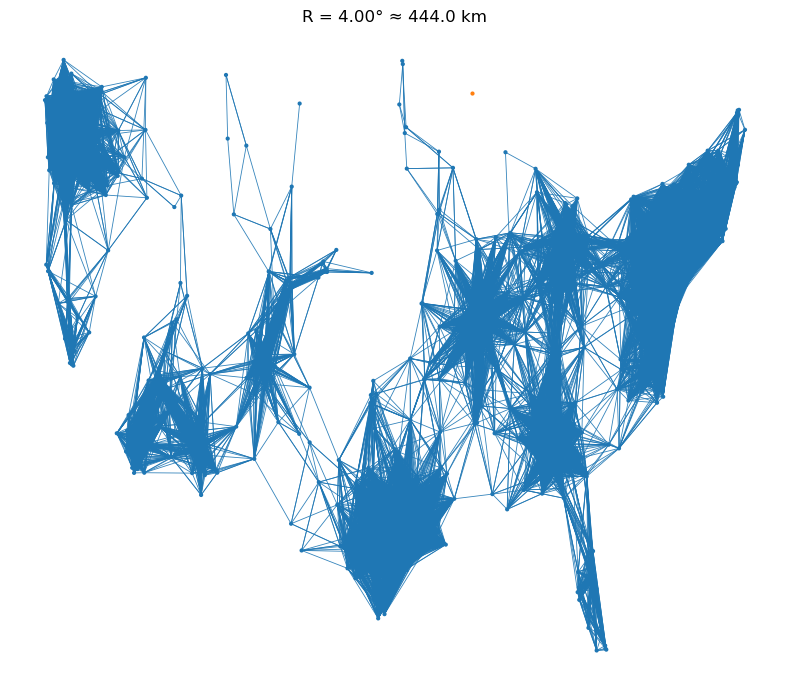

In [9]:
# Visualization
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot()
plot_largest_components_colored(ax, Gsamp, top_k=15, 
            color_map="tab10", linewidth = 0.6, linealpha = 0.9, nodesize = 4)
ax.set_title(f"R = {selected_radius:.02f}° ≈ {selected_radius * 111.0:.1f} km")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
# ax.axis('equal')
ax.axis("off")
plt.tight_layout()
plt.show()

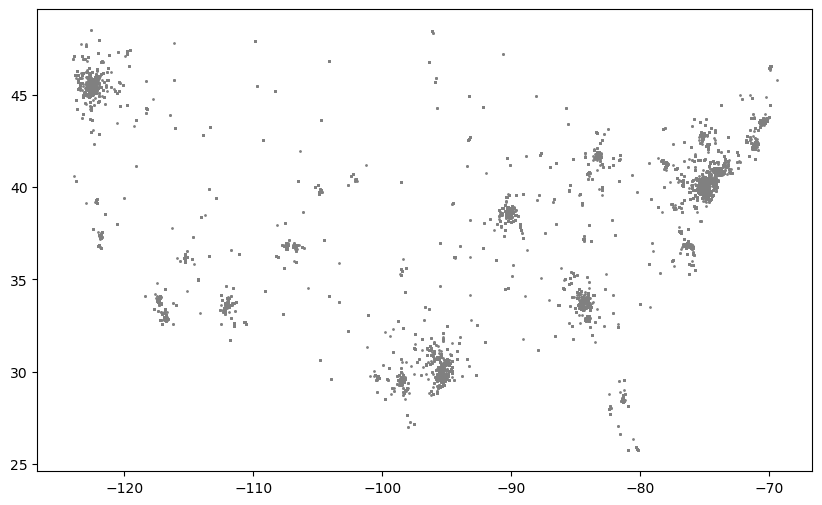

In [10]:
if 1: # debugging
    x, y = zip(*points_array)
    fig = plt.figure(figsize=(10, 6))
    inset_ax = fig.add_subplot()
    inset_ax.scatter(x, y, s=1, c="gray")

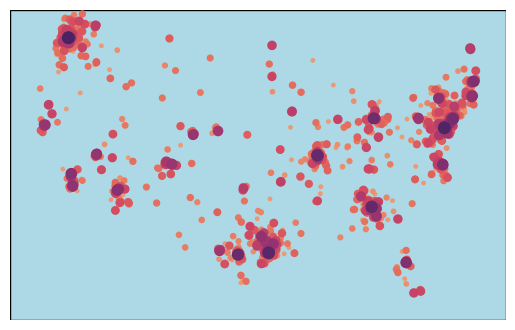

In [11]:
citymap = CityMapPlotter(points_array, "../Fig6/Data/" )
citymap.fig, citymap.ax = plt.subplots()
citymap.plot()


In [12]:
R_vals, CV_vals, mean_vals, std_vals = load_cv_data("./cv_tmp.csv", min_d=0.03)
taylor = TaylorLawFit()
taylor.fit(mean_vals, std_vals)
taylor.print_params()
mean_r = HyperbolicFitter(R_vals, mean_vals)
mean_r.print_params()
peak = PeakPredictor(R_vals, CV_vals, mean_r)
peak.fit()
r_star = peak.predict_peak()
if r_star:
    print(f"Predicted peak inequality scale r* = {r_star:.4f}")
mean_fit = mean_r.predict(R_vals)
std_fit = taylor.predict(mean_fit)

Initial guess p0: [np.float64(1.6719322492713924), np.float64(0.6414375770024316), np.float64(0.06294424053814739), np.float64(28.64451056841198)]
Bounds: ([-10, 0.1, 0.001, 1e-06], [10, 2.5, 10.0, np.float64(16666.666666666668)])
Composite Taylor's Law - Fitted parameters:
  c     = 23.1139
  γ     = 0.7246
  k     = 0.0775
  M₀    = 25.0439
μ(R) - Fitted parameters:
  c     = 53263.0165
  alpha = 0.6724
  beta  = 3.3629
  R_c   = 4.9392
Predicted peak inequality scale r* = 0.1313


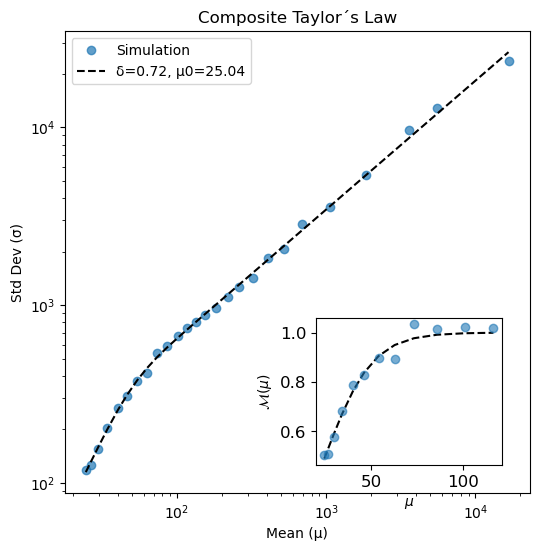

In [13]:
if 1: # debugging

    # ------------------ Panel F: Composite Taylor´s law
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot()
    taylor.plot_ax(ax, mean_vals, std_vals)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Mean (μ)')
    ax.set_ylabel('Std Dev (σ)')
    ax.legend()
    ax.set_title ("Composite Taylor´s Law")
    # --- plot inset : modulation function detail 
    inset_ax = inset_axes(ax,
            width="40%",  # relative to parent ax
            height="32%",
            loc='lower right',
            borderpad=2)  # space from edge
    inset_ax.patch.set_alpha(0.85)
    inset_ax.tick_params(labelsize=12)
    taylor.plot_modulation_ax (inset_ax, mean_vals, std_vals, 120)
    inset_ax.set_xlabel(r'$\mu$')
    inset_ax.set_ylabel(r'$\mathcal{M}(\mu)$')

/var/folders/0p/7lmr8bnx25z86qtgtdv9h4br0000gn/T/ipykernel_32158/2798710820.py:72: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='t', y='D', data=Omega, errorbar='sd', palette='flare', ax=ax)
/var/folders/0p/7lmr8bnx25z86qtgtdv9h4br0000gn/T/ipykernel_32158/2798710820.py:83: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='Rank', y='Count', data=zipf, errorbar='sd', ax=ax, palette='flare')
/var/folders/0p/7lmr8bnx25z86qtgtdv9h4br0000gn/T/ipykernel_32158/2798710820.py:114: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=LGG, x='D', y='N_c', errorbar='sd', palette='flare', ax=ax)
/var/folders/0p/7lmr8bnx25z86qtgtdv9h4br0000gn/T/ipykernel_32158/2798710820.py:278: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


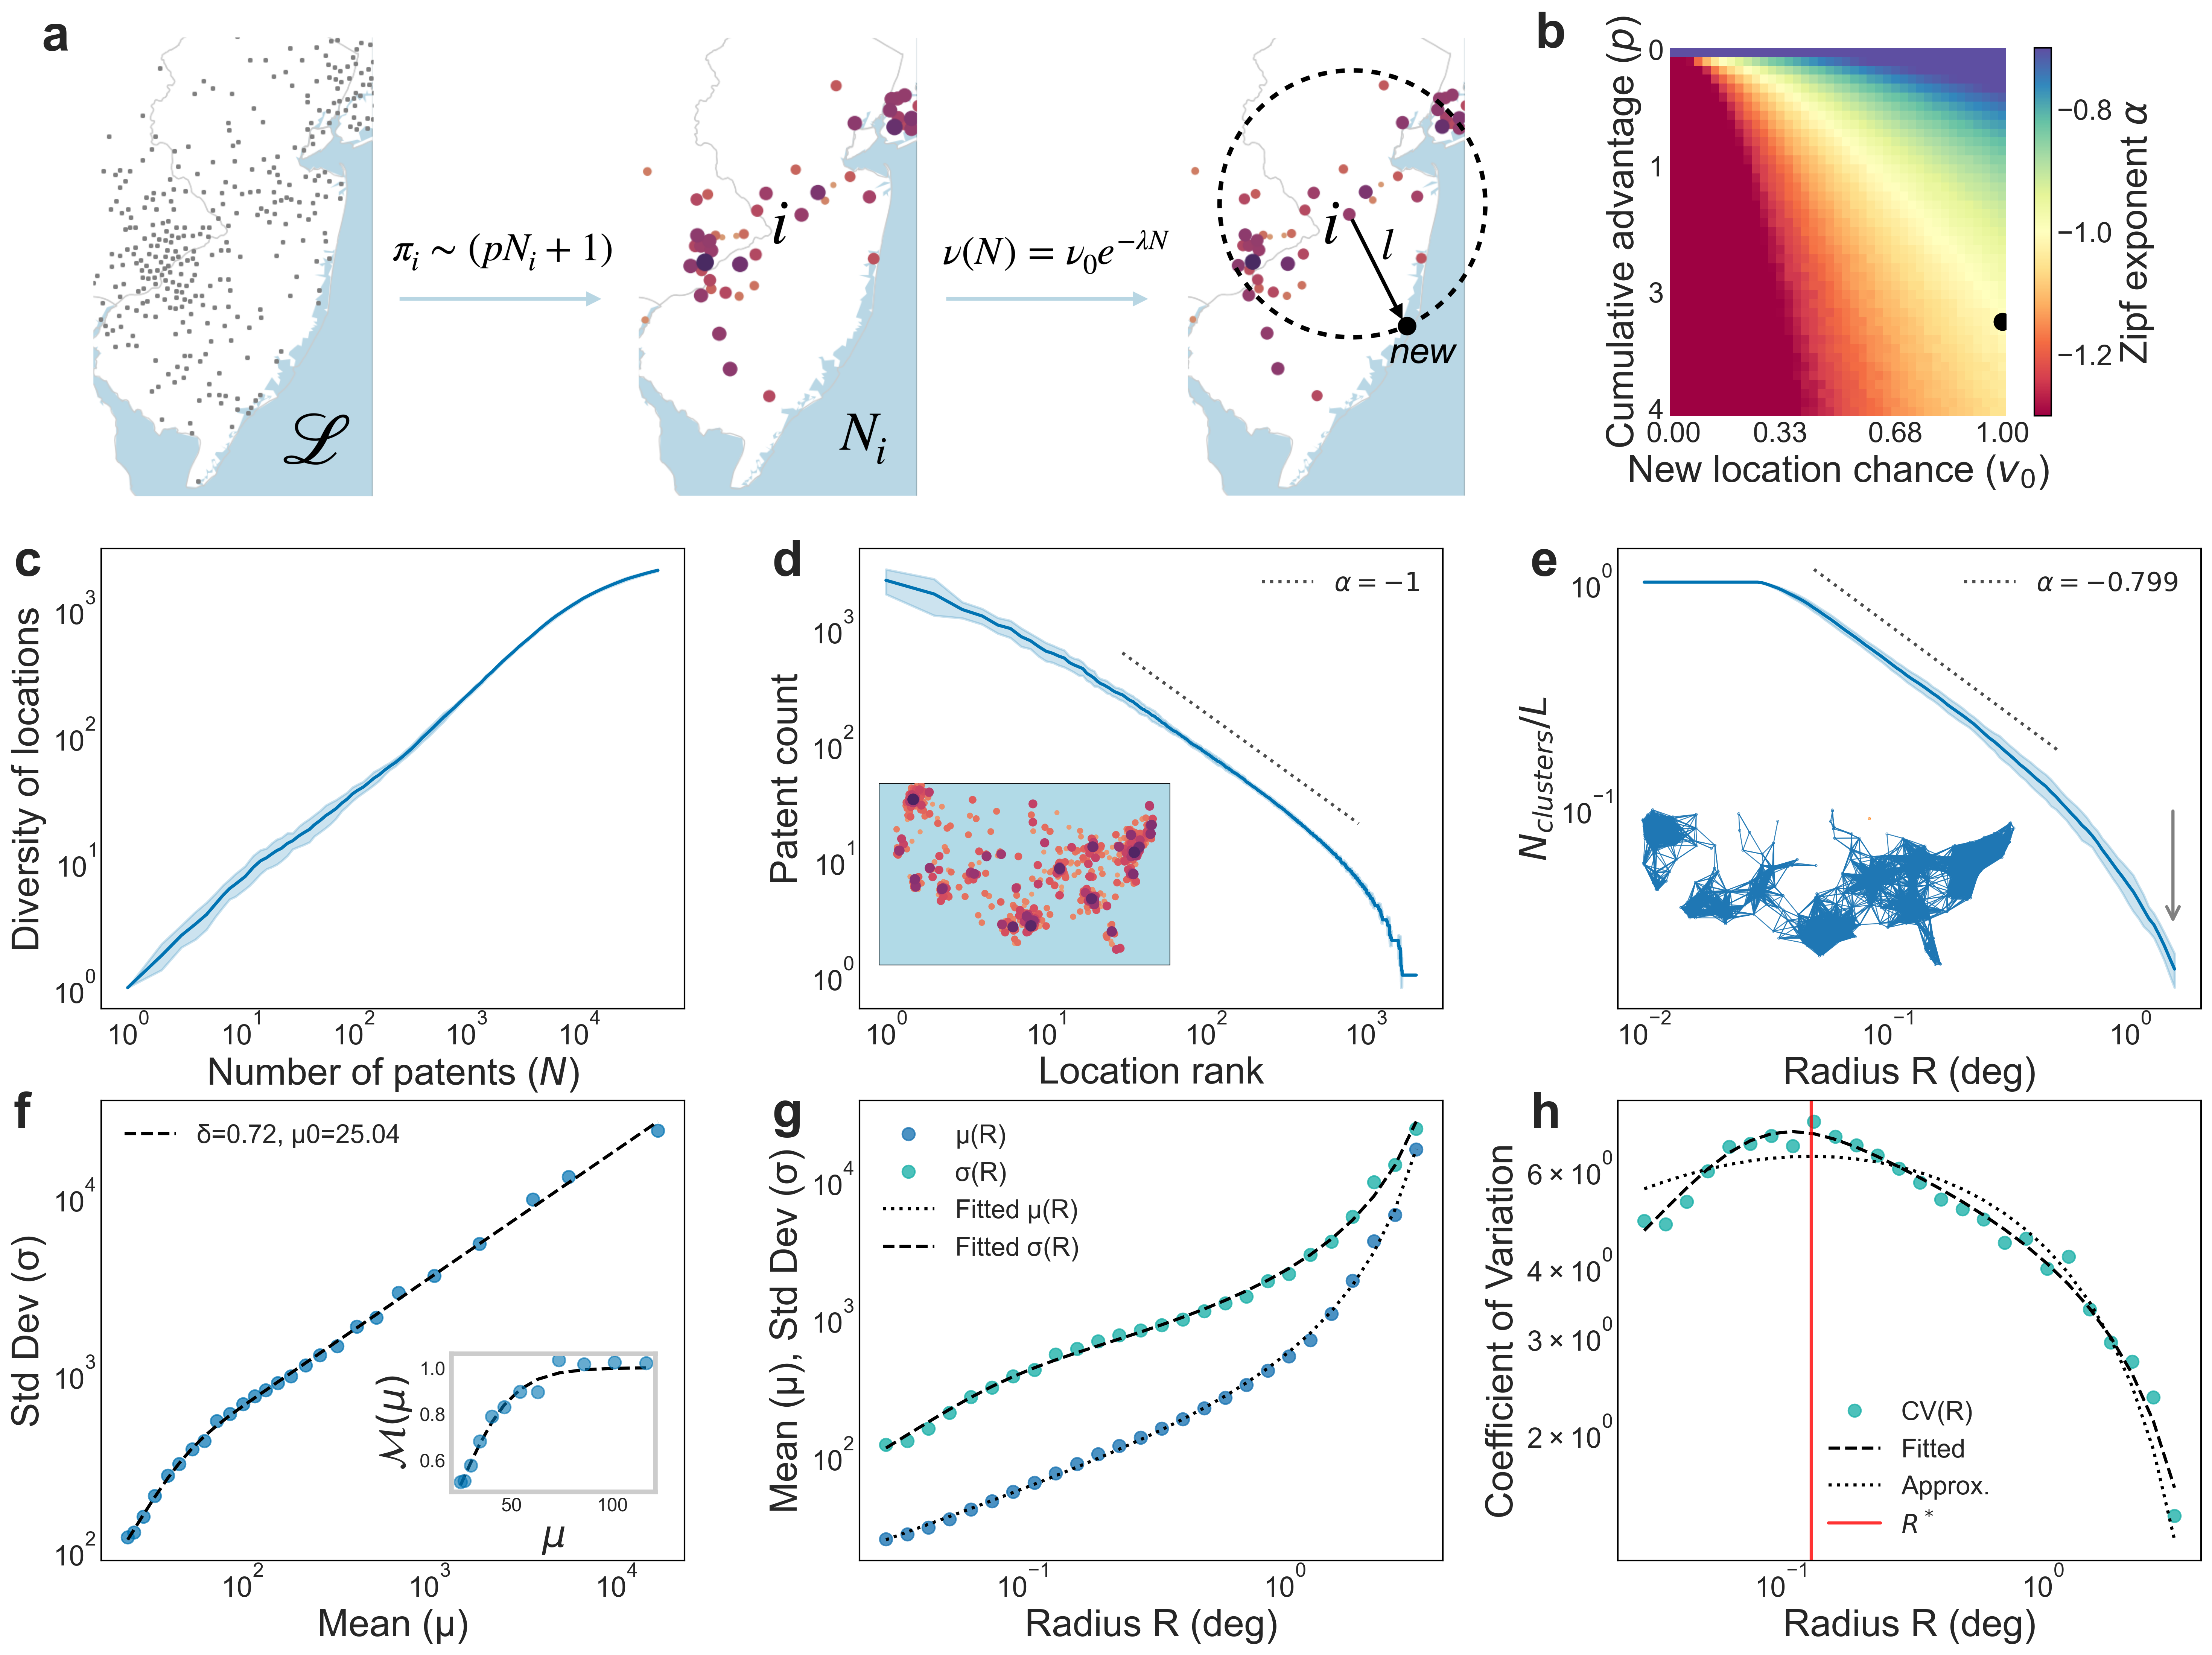

In [15]:
# Set Seaborn style
sns.set_context("talk")  # Larger text
sns.set_style("whitegrid")  # Clean background with grid

# Global style settings
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],  # Or Helvetica / DejaVu Sans
    'font.size': 2,
    'axes.labelweight': 'normal',
    'axes.linewidth': 3,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 8,
    'ytick.major.size': 8,
    'xtick.major.width': 4,
    'ytick.major.width': 4,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    'legend.frameon': False,
    'lines.linewidth': 2,
    'lines.markersize': 8,
    'axes.titlesize': 24,
    'axes.labelsize': 24,
    'figure.dpi': 300,
     "axes.grid": False,
})

# Optional: colorblind-friendly palette
sns.set_palette("colorblind")

fig = plt.figure(figsize=(24, 18))  # increased height a bit

outer_gs = gridspec.GridSpec(3, 3, height_ratios=[1.0, 1, 1], hspace=0.2, wspace=0.3)
# Create a subgridspec for the top row spanning all 3 columns, split into 2 equal parts
top_gs = gridspec.GridSpecFromSubplotSpec(1, 2, width_ratios = [1.5, 0.5], subplot_spec=outer_gs[0, :], wspace=0.2)

# -- Top Row --
ax_a = fig.add_subplot(top_gs[0, 0])  # left half
ax_b = fig.add_subplot(top_gs[0, 1])  # right half

# -- Middle Row --
ax_c = fig.add_subplot(outer_gs[1, 0])
ax_d = fig.add_subplot(outer_gs[1, 1])
ax_e = fig.add_subplot(outer_gs[1, 2])

# -- Bottom Row --
ax_f = fig.add_subplot(outer_gs[2, 0])
ax_g = fig.add_subplot(outer_gs[2, 1])
ax_h = fig.add_subplot(outer_gs[2, 2])

panel_label_height = 1.02  # Adjust this value to move the label up or down
panel_label_offset = -0.15  # Offset for panel label position
panel_label_fontsize = 32  # Font size for panel labels

# ------------------- Panel A: Diagram -----------------------------

pos = ax_a.get_position()
# new_width = pos.width * 1.20
ax_a.set_position([pos.x0-0.01, pos.y0-0.02, pos.width*1, pos.height*1])
img = mpimg.imread("model.png")
ax_a.imshow(img)
ax_a.axis('off')
# ax_a.set_title("Model Schematic")
# ax.text(-0.3, 1.2,
ax_a.text(-0.03, 
          1.05, 'a', transform=ax_a.transAxes, fontsize=panel_label_fontsize, 
          fontweight='bold', va='top', ha='left')

# ------------------Panel C: Diversity ---
ax = ax_c
sns.lineplot(x='t', y='D', data=Omega, errorbar='sd', palette='flare', ax=ax)
ax.set_xlabel('Number of patents ($N$)')
ax.set_ylabel('Diversity of locations')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_title('Diversity vs Patents')
ax.text(panel_label_offset, panel_label_height, 'c', transform=ax.transAxes, fontsize=panel_label_fontsize, 
        fontweight='bold', va='top', ha='left')

# ------------------ Panel D: Zipf law -----------------
ax = ax_d
sns.lineplot(x='Rank', y='Count', data=zipf, errorbar='sd', ax=ax, palette='flare')
ax.plot(np.arange(30, 900), 0.3 * (10 ** (params[1])) * np.arange(30, 900) ** (-1.0), ':', c=[0.3, 0.3, 0.3], label='$\\alpha = -1$')
ax.set_xlabel('Location rank')
ax.set_ylabel('Patent count')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_title('Zipf Law')
ax.legend()
ax.text(panel_label_offset, panel_label_height, 'd', transform=ax.transAxes, fontsize=panel_label_fontsize, 
        fontweight='bold', va='top', ha='left')
# Add Inset Axes in Bottom-Left 
inset_ax = inset_axes(ax,
        width="50%",  # relative to parent ax
        height="50%",
        loc='lower left',
        borderpad=0.75)  # space from edge
# OPTIONAL: Remove axis ticks if purely decorative
inset_ax.set_xticks([])
inset_ax.set_yticks([])
citymap.fig = fig
citymap.ax = inset_ax
citymap.plot(10.0)
#x, y = zip(*points_array)
#inset_ax.scatter(x, y, s=1, c="gray")
# Optional: outline the inset box visually
#inset_ax.set_frame_on(True)
inset_ax.set_frame_on(False)
inset_ax.patch.set_alpha(0.95)  # semi-transparent background

# ------------------ Panel E: LGG Clustering ---
ax = ax_e
sns.lineplot(data=LGG, x='D', y='N_c', errorbar='sd', palette='flare', ax=ax)
ax.plot(fit_x, fit_y, ':', c=[0.3, 0.3, 0.3], label=f'$\\alpha = {params_LGG[0]:.3f}$')
ax.set_xlabel('Radius R (deg)')
ax.set_ylabel('$N_{{clusters}}/L$')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(loc='upper right')
ax.text(panel_label_offset, panel_label_height, 'e', 
        transform=ax.transAxes, fontsize=panel_label_fontsize, 
        fontweight='bold', va='top', ha='left')
# Coordinates for the arrow at R= 4(location of the inset)
x_arrow = 1.5 # R inset
y_start = 0.1  # Adjust based on your plot range
y_end = 0.03    # Arrow points up to here
ax.annotate(
    '',  # no text
    xy=(x_arrow, y_end),      # arrow head
    xytext=(x_arrow, y_start),  # arrow tail
    arrowprops=dict(
        arrowstyle='->',
        color='gray',
        lw=2,
        mutation_scale=20  # <<< Increase this to enlarge arrow head
    )
)
# Add Inset Axes in Bottom-Left 
inset_ax = inset_axes(ax,
        width="70%",  # relative to parent ax
        height="50%",
        loc='lower left',
        borderpad=0.25)  # space from edge
# OPTIONAL: Remove axis ticks if purely decorative
inset_ax.set_xticks([])
inset_ax.set_yticks([])
inset_ax.axis('equal')
# Now you can plot inside this inset_ax like any other axes:
plot_largest_components_colored(inset_ax, Gsamp, top_k=15, 
            color_map="tab10", linewidth = 0.6, linealpha = 0.9, nodesize = 0.1)
# Optional: outline the inset box visually
#inset_ax.set_frame_on(True)
inset_ax.set_frame_on(False)
inset_ax.patch.set_alpha(0.95)  # semi-transparent background

# ------------------ Panel F: Composite Taylor´s law
ax = ax_f
taylor.plot_ax(ax, mean_vals, std_vals, None)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Mean (μ)')
ax.set_ylabel('Std Dev (σ)')
ax.legend()
# ax.set_title("Taylor's Law Fit")
ax.text(panel_label_offset, panel_label_height, 'f', 
        transform=ax.transAxes, fontsize=panel_label_fontsize, 
        fontweight='bold', va='top', ha='left')
# --- plot inset : modulation function detail 
inset_ax = ax.inset_axes( [.6, .15, .35, .3])
inset_ax.patch.set_alpha(0.85)
inset_ax.tick_params(labelsize=12)
taylor.plot_modulation_ax (inset_ax, mean_vals, std_vals, 120)
inset_ax.set_xlabel(r'$\mu$')
inset_ax.set_ylabel(r'$\mathcal{M}(\mu)$')

#inset_axes(ax,
#        width="30%",  # relative to parent ax
#        height="32%",
#        loc='lower right',
#        borderpad=3.0)  # space from edge

# ------------------ Panel G: Growth of mu and sigma 
ax = ax_g
ax.loglog(R_vals, mean_vals, 'o', label='μ(R)', color='tab:blue', alpha =0.8)
ax.loglog(R_vals, std_vals, 'o', label='σ(R)', color='lightseagreen', alpha =0.8)
ax.loglog(R_vals, mean_fit, ':', label='Fitted μ(R)', color='black')
ax.loglog(R_vals, std_fit, '--', label='Fitted σ(R)', color='black')
ax.set_xlabel('Radius R (deg)')
ax.set_ylabel('Mean (μ), Std Dev (σ)')
# ax.set_title("Fitted μ(R) and σ(R)")
ax.legend()
ax.text(panel_label_offset, panel_label_height, 'g', 
        transform=ax.transAxes, fontsize=panel_label_fontsize, 
        fontweight='bold', va='top', ha='left')

# ------------------ Panel H: Innovation Horizon (CV vs Radius) ------------------
ax = ax_h
cv = df_hoz['stdpat'] / df_hoz['meanpat']
# Plot
# ax.plot(df_hoz['scale'], cv, marker='o', color='tab:blue', markersize=5)
# ax.axvline(x=0.16, color='black', linestyle=':', linewidth = 3, label='Horizon Radius')  # Example vertical line
# ax.axvline(x=0.03, color='black', linestyle='--', linewidth = 3) 
# peak prediction 
ax.loglog(R_vals, CV_vals, 'o', label='CV(R)', color='lightseagreen', alpha = 0.8)
ax.loglog(R_vals, std_fit / mean_fit, '--', label='Fitted', color='black')
peak.plot_fit(ax)
# ax.set_title("CV(R) and Predicted Peak")
# ax.legend()
# Axis settings
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_xlabel('Radius (r)')
ax.set_xlabel('Radius R (deg)')
# ax.set_ylabel('CV(r)')
ax.set_ylabel('Coefficient of Variation')
# Grid and style
# ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Optional axis limits, if needed for clarity
# ax.set_xlim([min(df_hoz['scale']), max(df_hoz['scale'])])
# ax.set_ylim([min(cv)*0.8, max(cv)*1.2])
# Title and panel label
# ax.set_title("Innovation Horizon", fontsize=12)
ax.text(panel_label_offset, panel_label_height, 'h', 
        transform=ax.transAxes, fontsize=panel_label_fontsize, 
        fontweight='bold', va='top', ha='left')
ax.legend() 

# ------------------- Panel B: Morphospace Heatmap -----------------------------
ax = ax_b
# Define color map and norm
cmap = sns.color_palette("Spectral", as_cmap=True)
norm = plt.Normalize(vmin=-1.3, vmax=-0.7)
# --- Step 1: Shrink the heatmap axis width ---
# Get current position
pos = ax.get_position()
new_width = pos.width * 0.8
new_height = pos.height * 0.8
ax.set_position([pos.x0-0.02, pos.y0+0.02, new_width, new_height])
# --- Step 2: Create a divider for new colorbar ---
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.25)
# --- Step 3: Draw heatmap ---
sns.heatmap(M, annot=False, cmap=cmap, vmin=-1.3, vmax=-0.7,
            center=-1, ax=ax, cbar=False, linewidths=0.0)
# Get the actual axis positions for v and p in the heatmap
x, y = heatmap_coords(M, v, p)
# Overlay the scatter point
ax.scatter(x, y, s=100, color='black', zorder=5)
# Axis labels and panel label
ax.set_xlabel("New location chance ($v_0$)")
ax.set_ylabel("Cumulative advantage ($p$)")
ax.text(-0.4, 1.1, 'b', 
        transform=ax.transAxes, fontsize=panel_label_fontsize, 
        fontweight='bold', va='top', ha='left')
# ax.set_aspect('equal')
# --- Step 4: Clean tick labels ---
v_vals = M.columns.values
p_vals = M.index.values
v_idx = np.round(np.linspace(0, len(v_vals) - 1, 4)).astype(int)
p_idx = np.round(np.linspace(0, len(p_vals) - 1, 4)).astype(int)
ax.set_xticks(v_idx + 0.5)
ax.set_xticklabels([f"{v_vals[i]:.2f}" for i in v_idx], rotation=0)
ax.set_yticks(p_idx + 0.5)
ax.set_yticklabels([f"{p_vals[i]:.0f}" for i in p_idx], rotation=0)
# --- Step 5: Colorbar ---
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label("Zipf exponent $\\alpha$")

# --- EPILOGUE: Set spine color and width ---
# Set spine color and width for all axes
for ax in fig.axes:
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1)
plt.tight_layout()
plt.savefig("Fig6.pdf")
# plt.savefig("Fig6.png", dpi=300)
plt.show()